# Face classification with Neural Networks

## Set up

In [1]:
# Stdlib imports
from pathlib import Path
import os

# 3rd party imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D 
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score 
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, f1_score
from sklearn.metrics import r2_score

from IPython.display import display

# Local imports
from facecls import fcaux, fcmodels

2024-07-08 02:57:06.699452: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load data

Let's load the preprocessed data set from the CSV file. It contains the images and four possible attributes/targets: "gender", "ethnicity", "age", and "age_decades".

In [2]:
data = pd.read_csv("data/age_gender_preproc.csv")

## Configurations

Next, we define for which of the four targets the classifier shall be trained in this notebook and with what CNN architecture:

In [3]:
target = "gender"  # other options: "ethnicity", "age_decades", "age"
nn_architecture = "my_cnn"  # other options: "mlp", "my_cnn", "lenet", "vgg", "resnet"

Also, we create a new directory specifically for the model that we will train in this notebook:

In [4]:
# Define a variable containing the root directory for all models
models_dir = Path(f"results/models/{target.title()}Classifier/")

# Identify the ID of the last, already existing model of the specified 
# CNN architecture.
try:
    last_model_id = max([int(folder.as_posix().split("_")[2]) 
                         for folder in models_dir.glob(f'{nn_architecture}*')
                        ])
except ValueError:
    # If no model of the specified architecture exists yet, set the last 
    # model ID = 0, so that the model created now will have ID = 1
    last_model_id = 0 

# Just to check that all is right, print the identified ID of the last, existing
# model.
print("Last model id:", last_model_id)

# ID of the model that we will create now
new_model_id = last_model_id + 1

# Variable file_suffix contains info about the model architecture, the target
# and the model ID. This variable will be reused several times in this notebook
# and defines a naming convention.
file_suffix = f"{nn_architecture}_{target}_{str(new_model_id).zfill(3)}"

# Create a directory for the model created here
new_model_dir = models_dir / file_suffix
print(f"Creating folder \"{new_model_dir}\"...")
new_model_dir.mkdir(parents=True, exist_ok=True)

Last model id: 0
Creating folder "results/models/GenderClassifier/my_cnn_gender_001"...


## Model build

In this section, we will build the classifier using the CNN architecture defined above. The first step to do is to prepare the data:

In [5]:
seed = fcaux.set_seed(42)

### Convert data from strings (as read from file) to arrays

In [7]:
# Use helper function to convert the pixel string 
# first into a pixel vector...
X_in = np.array([fcaux.pxlstring2pxlvec(data, i) for i in range(data.shape[0])])

if nn_architecture != "mlp":
    # ...and, if the model is a CNN, then convert the pixel vector into a pixel array
    X_in = np.array([fcaux.pxlvec2pxlarray(img_vec) for img_vec in X_in])

### Data split

As usual we split the data set into a training, validation and a test set. The test set is made of 20% of the entire data set, the validation set of 10% of the remaining 80% (i.e. of 8% of the entire data set) and therefore 72% of the full data set make up the training set.

Notice that we perform the split using indices and not on the feature and target data directly. The motivation is so we can later just safe the train, validation and test example indices in a CSV file which saves more disk space than saving new copies of the full data for each model.

In [8]:
attrs = data[["gender", "ethnicity", "age_decades"]]
all_indices = range(len(X_in))

# Stratification is only possible for categorical targets
if target == "age":
    strat = None
else:
    strat = attrs[target].values

# Perform the train-test split
idx_train, idx_test = train_test_split(all_indices,
                                       test_size = 0.2,
                                       stratify = strat,
                                       random_state=seed
                                      )

# Perform the train-val split
idx_train, idx_val  = train_test_split(idx_train,
                                       test_size = 0.1,
                                       stratify = strat[idx_train],
                                       random_state=seed
                                      )

Now use those indices to extract the corresponding features/images and targets:

In [9]:
# First, extract column index for target column ...
target_idx = attrs.columns.get_loc(target)

# ... because we need this to slice the data sets using iloc
X_train = X_in[idx_train]
y_train = attrs.iloc[idx_train, target_idx]

X_val = X_in[idx_val]
y_val = attrs.iloc[idx_val, target_idx]

X_test = X_in[idx_test]
y_test = attrs.iloc[idx_test, target_idx]
attrs_test = attrs.iloc[idx_test, :]

In [10]:
# Just checking: number of elements per data subset
print("#training:", len(X_train))
print("#validation:", len(X_val))
print("#test:", len(X_test))

#training: 17067
#validation: 1897
#test: 4741


Now save the three different index data sets to file:

In [11]:
# In order to pack all three index vectors into one single pd.DataFrame
# they all need to be of the same length. To achieve this, we fill the
# test and validation index vectors with NaNs until they have the same
# length as the training index vector.
idx_val += (len(idx_train) - len(idx_val))*[np.nan]
idx_test += (len(idx_train) - len(idx_test))*[np.nan]

# Check that the vectors are now all of equal length
assert len(idx_train) == len(idx_val)
assert len(idx_train) == len(idx_test)

# Pack all three index vectors into a single pd.DataFrame for easy
# and convenient writing to file.
idx_df = pd.DataFrame({"train_idx": idx_train,
                       "val_idx": idx_val,
                       "test_idx": idx_test}, dtype="Int64")

idx_df.to_csv(new_model_dir / f"data_set_indices__{file_suffix}.csv", index=False)

### Data preprocessing

In order to train the model later on, we first need to make sure the data is in a suitable format. Specifically this means:

- the input tensors X_* need to be of shape (n_X, width, height, n_channels), where n_X is the number of examples in the tensor X_*, width and height are the pixel dimensions of each image and n_channels is the number of channels used in the image. Specifically, we are working with grayscale images, i.e. n_channels = 1.
- The pixel values need to be of type float
- The pixel values need to be normalized to the range between [0,1].
- If the target is age_decades, we need to make sure the age_decade classes are labelled by consecutive indices

In [12]:
# Upsample images if required by CNN architecture
if nn_architecture in ["LeNet", "AlexNet", "VGG", "ResNet"]:
    newdim = 227
    X_train = np.array([fcaux.upsample_image(X_train, newdim, newdim) for X in X_train])
    X_val = np.array([fcaux.upsample_image(X_val, newdim, newdim) for X in X_val])
    X_test = np.array([fcaux.upsample_image(X_test, newdim, newdim) for X in X_test])

In [13]:
# Preprocess the data: fix the shape and data type and normalize
if nn_architecture == "mlp":
    add_channels = False
else:
    add_channels = True

X_train = fcaux.preproc_data(X_train, add_channels_dim = add_channels)
X_val = fcaux.preproc_data(X_val, add_channels_dim = add_channels)
X_test = fcaux.preproc_data(X_test, add_channels_dim = add_channels)

In [14]:
# If the target is "age_decades", we need to generate consecutive data
# classes as classes 10, 20, 30 etc. or 5, 10, 15, etc. are not accepted
# by keras.utils.to_categorical called below
if target == "age_decades":
    y_train /= age_diff
    y_val /= age_diff
    y_test /= age_diff

In [15]:
# Compute the number of classes for the current classification problem.
# This number will be the dimension of the output layer in the neural 
# network to be built.
if target == "age":
    # If target == "age", we are solving a regression and not a classifiction
    # problem, i.e. there are no classes. 
    num_classes = 0
else:
    num_classes = data[target].nunique()
    #if nn_architecture != "mlp":
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_val = keras.utils.to_categorical(y_val, num_classes)

print("num_classes =", num_classes)

num_classes = 2


### Building the CNN model 
Here we define the model according to the CNN architecture definition specified in the configurations section above:

In [16]:
if nn_architecture == "mlp":
    model = fcmodels.mlp(num_classes, X_train[0].shape)
elif nn_architecture == "my_cnn":
    model = fcmodels.my_cnn(num_classes)
elif nn_architecture == "lenet":
    pass
elif nn_architecture == "alexnet":
    model = fcmodels.model(num_classes)
elif nn_architecture == "vgg":
    pass
elif nn_architecture == "resnet":
    pass

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 44, 44, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 44, 44, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 18, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       663,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 728,194 (2.78 MB)

 Trainable params: 728,194 (2.78 MB)

 Non-trainable params: 0 (0.00 B)

### Train model until overfitting
Now we are finally ready to train the model. We do so by fitting the previously defined model to the training data for a maximal number n_epochs epochs. During the training, we measure the validation loss and use early stopping based on the validation loss in order to avoid overfitting. We use this approach not just find the optimal value of epochs but also to generate evidence that if more epochs are used the model would overfit.

In [17]:
# Maximum number of epochs
n_epochs = 50

# Definition of early stopping callback: make sure to restore the best weights
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    epochs=n_epochs,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    callbacks=[early_stopping]
                   )

# Save the optimal model
model.save(new_model_dir / f'{file_suffix}__nepochs{n_epochs}.keras')

Epoch 1/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 39s 285ms/step - accuracy: 0.6986 - loss: 0.5575 - val_accuracy: 0.8587 - val_loss: 0.3318
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 40s 296ms/step - accuracy: 0.8512 - loss: 0.3372 - val_accuracy: 0.8735 - val_loss: 0.2894
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 42s 315ms/step - accuracy: 0.8751 - loss: 0.2842 - val_accuracy: 0.8856 - val_loss: 0.2631
Epoch 4/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 41s 305ms/step - accuracy: 0.8925 - loss: 0.2503 - val_accuracy: 0.8946 - val_loss: 0.2447
Epoch 5/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 41s 309ms/step - accuracy: 0.9058 - loss: 0.2263 - val_accuracy: 0.8930 - val_loss: 0.2361
Epoch 6/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 42s 311ms/step - accuracy: 0.9143 - loss: 0.2075 - val_accuracy: 0.9030 - val_loss: 0.2495
Epoch 7/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 42s 310ms/step - accuracy: 0.9188 - loss: 0.1979 - val_accuracy: 0.9025 - val_loss: 0.2341
Epoch 8/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 42s 310ms/step - accuracy: 0.9328 - loss: 0

Let's now have a look at the loss curve to make sure the training process went as expected. First we put the data in a pandas.DataFrame, then we save that to a CSV file...

In [18]:
history = model.history.history  # Just for simplification/convenience

# Count the actual number of epochs (may be less than defined due to early stopping)
n_epochs = len(model.history.history["loss"])

# Add an explicit "epoch" key with values enumerating the epochs
history["epoch"] = list(range(1, n_epochs+1))

# In general we don't know the names of the other keys of the history dictionary
# as they depend on the specific configuration of the model training process.
# Therefore, extract those unknown keys.
other_columns = [k for k, v in history.items() if k!="epoch"] 

# Convert the history dictionary into a dataframe (with 'epoch' as first column)
# for convenient saving.
history_df = pd.DataFrame(history, columns = ["epoch"] + other_columns)
file_name = f'history__{file_suffix}__nepochs{n_epochs}.csv'
history_df.to_csv(new_model_dir / file_name, index=False)

# Remark: by creating the column "epoch" and by setting the index kwarg in
# the last line to False, the epoch enumarting column has actually in the
# saved CSV file (otherwise there wouldn't be a name and when loading the file
# again from disk there would be a generic "Unnamed: 0".

...and last but not least, we plot it:

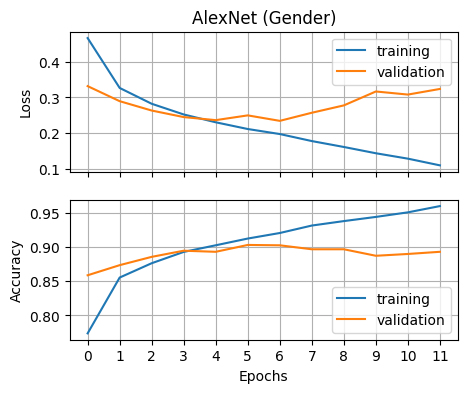

In [19]:
fig, axs = plt.subplots(2,1, figsize=(5,4), sharex=True)
ax = axs[0]  # panel for loss curves
ax.plot(history["loss"], label="training")
ax.plot(history["val_loss"], label="validation")
ax.grid(True)
ax.set_xticks(range(n_epochs))
ax.set_ylabel("Loss")
ax.set_title(f"AlexNet ({target.title()})")
ax.legend(loc="best")

ax = axs[1]  # panel for accuracy curves
ax.plot(history["accuracy"], label="training")
ax.plot(history[f"val_accuracy"], label="validation")
ax.grid(True)
ax.set_xticks(range(n_epochs))
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend(loc="best")

# Save figure to disk
plt.savefig(new_model_dir / f"loss_curve__{file_suffix}__nepochs{n_epochs}.png",
            bbox_inches='tight')
plt.show()

At this point we have trained the model and save information about the training process.

## Model validation

### Basic classification performance metrics
Next validate the model by testing it on the so far unseen test data. While doing so, look at other metrics such as balanced accuracy, ROC AUC and F1 scores, too.

In [20]:
# Evaluate the model on training, validation, and test set.
# First, the y_prob* variables contain the predicted class probabilities 
# which will be used in the ROC AUC computation. To compute the other 
# metrics, use the predicted class labels (given in y_pred*).
y_prob_train = model.predict(X_train)
y_pred_train = np.array([np.argmax(i) for i in y_prob_train])

y_prob_val = model.predict(X_val)
y_pred_val = np.array([np.argmax(i) for i in y_prob_val])

y_prob_test = model.predict(X_test)
y_pred_test = np.array([np.argmax(i) for i in y_prob_test])

534/534 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


In [21]:
# Compute all the metrics for train, validation and test set 
# and combine them into respective dictionaries for convenient handling
train_metrics = {"accuracy": accuracy_score(np.array([np.argmax(i) for i in y_train]), y_pred_train),
                 "balanced_accuracy": balanced_accuracy_score(np.array([np.argmax(i) for i in y_train]), y_pred_train),
                 "roc_auc": roc_auc_score(np.array([np.argmax(i) for i in y_train]), y_prob_train[:,1]),
                 "F1": f1_score(np.array([np.argmax(i) for i in y_train]), y_pred_train)}

val_metrics = {"accuracy": accuracy_score(np.array([np.argmax(i) for i in y_val]), y_pred_val),
               "balanced_accuracy": balanced_accuracy_score(np.array([np.argmax(i) for i in y_val]), y_pred_val),
               "roc_auc": roc_auc_score(np.array([np.argmax(i) for i in y_val]), y_prob_val[:,1]),
               "F1": f1_score(np.array([np.argmax(i) for i in y_val]), y_pred_val)}

test_metrics = {"accuracy": accuracy_score(y_test, y_pred_test),
                "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_test),
                "roc_auc": roc_auc_score(y_test, y_prob_test[:,1]),
                "F1": f1_score(y_test, y_pred_test)}

# Combine all data sets into a pandas.DataFrame for convenient saving
metrics_df = pd.DataFrame({"train": train_metrics, 
                           "val": val_metrics, 
                           "test": test_metrics})

display(metrics_df)
metrics_df.to_csv(new_model_dir / f"metrics__{file_suffix}.csv")

,train,val,test
accuracy,0.929806,0.902478,0.894115
balanced_accuracy,0.929346,0.902296,0.893188
roc_auc,0.981384,0.967734,0.962421
F1,0.925931,0.897846,0.887242


In [22]:
# Further more, produce and save the the false positive and true positive 
# rates and save them to disk.
fpr, tpr, thr = roc_curve(y_test, y_prob_test[:,1])
pd.DataFrame({"FPR": fpr, "TPR": tpr}).to_csv(new_model_dir / f"fpr_vs_tpr__{file_suffix}.csv")

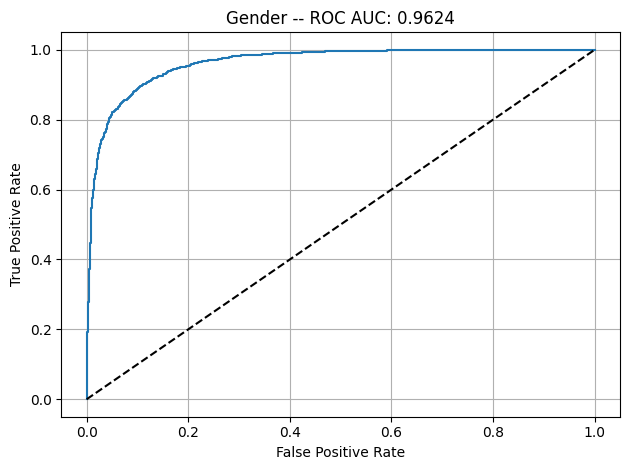

In [23]:
# Use the previously computed FPRs and TPRs to plot the ROC curve.
fig, ax = plt.subplots()
ax.plot(fpr,tpr)
ax.plot([0,1], [0,1], ls="--", c="k")
ax.grid(True)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title(f"{target.title()} -- ROC AUC: {np.round(roc_auc_score(y_test, y_prob_test[:,1]),4)}")
plt.tight_layout()
plt.savefig(new_model_dir / f"roc_curve__{file_suffix}.png",
            bbox_inches='tight')
plt.show()

In [24]:
# Last but not least, produce a classification report to get more quantitative
# information about the classification performance.
cls_report = pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True))
display(cls_report)
cls_report.to_csv(new_model_dir / f"classificationo_report__{file_suffix}.png")

,0,1,accuracy,macro avg,weighted avg
precision,0.887147,0.902238,0.894115,0.894693,0.894351
recall,0.913640,0.872735,0.894115,0.893188,0.894115
f1-score,0.900199,0.887242,0.894115,0.893720,0.894014
support,2478.000000,2263.000000,0.894115,4741.000000,4741.000000


### Bias & fairness analysis

The key focus of this project is to work towards an unbiased and fair classifier. Let's therefore investigate potential biases that are left in this classifier so we can lateron try to reduce/remove them.

Create a dictionary with performance metrics by the two non-target attributes. In other words, assuming that "gender" is the target attribute used to train the model, let's split the test data into individual ethnicity and/or age_decades groups and see how the model performs on each of these groups. If the model does not perform equally (or at least similarly) well on all groups, there are biases we should try to reduce.

In [25]:
test_data = attrs_test.copy()
test_data = test_data.reset_index()

In [27]:
# Initialize the dict to hold the performance metrics
performance_df = dict()

# Iterate over all non-target attributes
non_targets = [a for a in attrs.columns if a!=target]
for attr in non_targets:
    # Print info for human-readablity
    print(attr)
    print("="*len(attr))

    # Create sub-dicts for subgroups of current attr
    subgroups = dict()  # will contain all test examples falling in each subgroup
    performance_by_subgroup = dict()  # will contain performance metrics for each subgroup

    # Iterate over all subgroups of current attr
    for gidx in test_data[attr].unique():
        # Find all test example in the current subgroup
        subgroups[gidx] = list(test_data[test_data[attr]==gidx].index)

        # For these examples, predict the gender class probabilities and class labels
        y_prob_subg = model.predict(X_test[subgroups[gidx]])
        y_pred_subg = np.array([np.argmax(i) for i in y_prob_subg])

        # Using the predicted and true probabilities and labels, compute the performance
        # metrics: accuracy, balanced accuracy, F1 score and ROC AUC score
        acc = accuracy_score(y_test.iloc[subgroups[gidx]], y_pred_subg)
        balacc = balanced_accuracy_score(y_test.iloc[subgroups[gidx]], y_pred_subg)
        F1 = f1_score(y_test.iloc[subgroups[gidx]], y_pred_subg)
        try:
            rocauc = roc_auc_score(y_test.iloc[subgroups[gidx]], y_prob_subg[:,1])
        except ValueError:
            rocauc = np.nan

        # ... and store them all into a dictionary
        performance_by_subgroup[gidx] = {"accuracy": acc,
                                         "balanced_accuracy": balacc,
                                         "ROC_AUC": rocauc,
                                         "F1": F1}
    
    # Convert to data frame for easier plotting
    sorted_columns = sorted([k for k,v in performance_by_subgroup.items()])
    performance_df[attr] = pd.DataFrame(performance_by_subgroup, 
                                     columns = sorted_columns).transpose()    

ethnicity
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
age_decades
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/Users/mischaknabenhans/Desktop/LEARNING/Lectures/OnlineLectures/Coursera/DL_and_RL/FaceClassifier/face_cls_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Let's visualize the computed metrics:

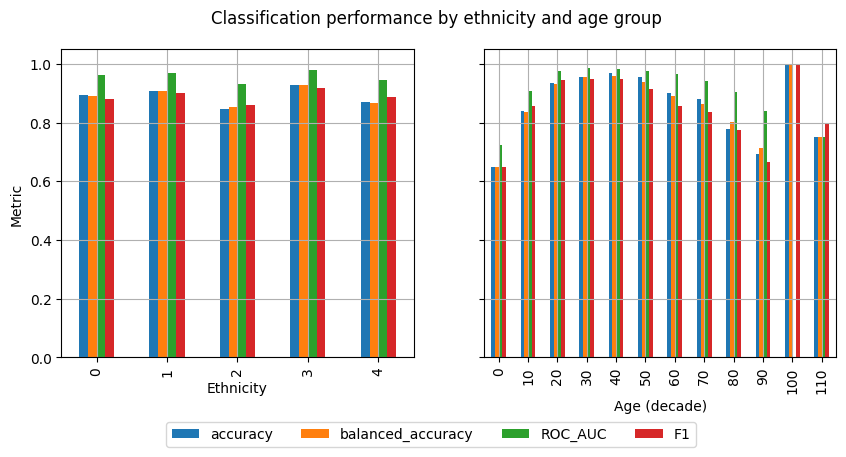

In [28]:
fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=True, gridspec_kw = {"hspace": 0.07})
ax = axs[0]
performance_df["ethnicity"].plot(kind="bar", ax = ax, grid=True, legend=False)
ax.set_xlabel("Ethnicity")
ax.set_ylabel("Metric")

ax = axs[1]
performance_df["age_decades"].plot(kind="bar", ax = ax, grid=True)
ax.set_xlabel("Age (decade)")
ax.legend(loc="center", bbox_to_anchor=(-0.15,-0.25), ncol=4)

fig.suptitle("Classification performance by ethnicity and age group")

plt.savefig(new_model_dir / f"cls_performance_analysis__{file_suffix}.png", 
            bbox_inches='tight')
plt.show()

While these visualizations give an intuitive picture of the biases that are present in the current model, we should try to quantify them as well. To do so, one can study the variability of the performance metrics around the mean value. As the number of samples (attribute subgroups) is quite small, the spread should be considered on top of the standard deviation to get an idea of the variability. The smaller these variability values are, the less biased the model is (as all performance values are very similar for all attribute subgroups).

In [29]:
for attr in non_targets:
    stats = dict()  # Dictionary to be populated with performance stats
    for col in performance_df[attr]:
        # Compute performance stats (per attribute subgroup) and
        # populate 'stats' with them.
        stats[col] = {"mean": performance_df[attr][col].mean(),
                      "std": performance_df[attr][col].std(),
                      "spread": performance_df[attr][col].max() - performance_df[attr][col].min()
                     }

    # Convert dictionary to pd.DataFrame (again for convenient writing)
    stats_df = pd.DataFrame(stats)

    # Print and display the results
    print(attr)
    print("=" * len(attr))
    display(stats_df)
    print()

    stats_df.to_csv(new_model_dir / f"performance_stats__{attr}__{file_suffix}.csv", index=False) 

ethnicity


,accuracy,balanced_accuracy,ROC_AUC,F1
mean,0.890037,0.889503,0.957813,0.889547
std,0.031221,0.030027,0.019693,0.021522
spread,0.079882,0.075048,0.049728,0.056071



age_decades


,accuracy,balanced_accuracy,ROC_AUC,F1
mean,0.858752,0.857569,0.905335,0.850168
std,0.116442,0.109722,0.094501,0.111960
spread,0.352531,0.350159,0.263931,0.350694
